# Sieci neuronowe 1 - LAB

    prowadzący: Monika Wasilewska
    Politechnika Wrocławska, Katedra Akustyki, Multimediów i Przetwarzania Sygnałów
    

Run a cell via `Shift + Return`. Learn more about [CoCalc Jupyter Notebooks](https://doc.cocalc.com/jupyter.html).

---
Plan zajęć:
---
1. Zapoznanie się z pojęciem sieci typu "koder - dekoder"
2. Przetrenowanie poznanego pojęcia na gotowym przykładzie.
3. Stworzenie sieci typu enkoder-dekoder dla MNIST-10
3. Stworzenie sieci odszumiającej dla MNIST-10
---

Dzisiejsze zajęcia to już trochę bardziej zaawansowane sieci, które można wykorzystać do wielu celów. Sieci typu koder-dekoder mogą być zbudowane "w środku" zarówno z warstw LP jak również warstw konwolucyjnych. Najważniejszym jest zrozumienie idei jak ta sieć działa. 

Nie jestem tylko pewna ile było już na ten temat na wykładzie. W razie potrzeby na kolejnych zajęciach jeszcze raz wyjaśniemy sobie ideę poznawanego właśnie przez Was mechanizmu. **Miłej nauki i... zabawy!**

---

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Zadanie 1
Zapoznaj się z dwoma pierwszymi przykładami z [tutoriala TensorFlow](https://www.tensorflow.org/tutorials/generative/autoencoder ) dotyczącego właśnie autenkoderów. Autoenkodery są to sieci potrafiące odtworzyć podane wejście z zakodowanych cech na wyjściu sieci. Oznacza to, że skaładają się z dwóch powiązanych ze sobą części:
- kodera
- dekodera.

Pierwsza z nich pozwala nasz oryginalny obrazek zmniejszyć do pewnego wektora cech z którego dekoder nauczy się odtwarzać obrazek. Z racji że nie mamy teraz do czynienia z klasyfikacją zmieni się np. wykorzystywana funkcja błędu, czy dane które będziemy przekazywać w procesie uczenia.
**Przeanalizuj DWA pierwsze przykłady. Trzecim zajmiemy się na kolejnych zajęciach.** 

UWAGA: Ze strony można ściągnąć notebooka, aby przetestować u siebie zmianę parametrów sieci do czego gorąco zachęcam! (Przy czym notebbok będzie w j. angielskim, tutorial jest całkiem nieźle napisany również po polsku)

# Zadanie 2
Stwórz autoenkoder dla bazy `CIFAR-10`. Wyrysuj otrzymane wyjście względem wejścia i porównaj rysunki (zastanów się które warto obejrzeć). **Możesz skorzystać z architektury podobnej do tej, którą wykorzystałeś na poprzednich zajęciach (prawie że skopiować klasyfikator jako koder i dopisać tylko dekoder).** Zmień parametry sieci (liczbę warstw, neuronów...) i zaobserwuj różnice. Zaprojektowaną Przez Ciebie sieć wykorzystamy na kolejnych zajęciach.

UWAGA: Jeśli czas uczenia sieci jest bardzo długi ze względu na liczbę klas i przykładów możecie ograniczyć swoją bazę wybierając 3-4 klasy. 

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Limit dataset size
class_indices = [1, 3, 5, 7]

train_indices = [i for i, y in enumerate(train_labels) if y in class_indices]
test_indices = [i for i, y in enumerate(test_labels) if y in class_indices]

train_images, train_labels = train_images[train_indices], train_labels[train_indices]
test_images, test_labels = test_images[test_indices], test_labels[test_indices]

train_images = train_images / 255.0
test_images = test_images / 255.0

class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),metrics=['accuracy'])
autoencoder.fit(train_images, train_images,
                epochs=5,
                shuffle=True,
                validation_data=(test_images, test_images))

autoencoder.summary()

2023-02-04 20:09:30.042319: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0163 - accuracy: 0.5993 - val_loss: 0.0100 - val_accuracy: 0.6485
Epoch 2/5
625/625 [==============================] - 7s 12ms/step - loss: 0.0090 - accuracy: 0.6721 - val_loss: 0.0082 - val_accuracy: 0.7117
Epoch 3/5
625/625 [==============================] - 7s 12ms/step - loss: 0.0077 - accuracy: 0.7158 - val_loss: 0.0074 - val_accuracy: 0.7104
Epoch 4/5
625/625 [==============================] - 7s 12ms/step - loss: 0.0071 - accuracy: 0.7299 - val_loss: 0.0069 - val_accuracy: 0.7312
Epoch 5/5
625/625 [==============================] - 7s 12ms/step - loss: 0.0068 - accuracy: 0.7383 - val_loss: 0.0066 - val_accuracy: 0.7437
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8, 8, 8)           1608      
                                                                 
 sequ

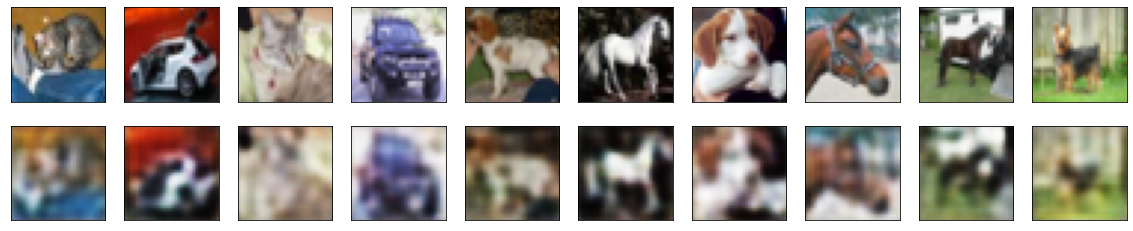

In [3]:
# Compression and reconstruction
encoded_images = autoencoder.encoder(test_images).numpy()
decoded_images = autoencoder.decoder(encoded_images).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Zadanie 3
Zapisz model, tak aby można było później z niego skorzystać. Jak to zrobić znajdziesz tutaj: [CLICK!](https://keras.io/api/models/model_saving_apis/). 

In [4]:
#Save model
autoencoder.save('model')

2023-02-04 20:10:12.003822: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


# Zadanie 4
Wczytaj zapisany przed momentem model do nowej zmiennej (np. `loaded_model`) i doucz go jeszcze na kilku epokach. Od jakiej wartości błędu startujemy?

In [5]:
loaded_model = tf.keras.models.load_model('model')
loaded_model.summary()

loss, acc = loaded_model.evaluate(test_images,  test_labels, verbose=2)
print(f"Accuracy: {acc} Loss: {loss}")

loaded_model.fit(train_images, train_images, epochs=4, shuffle=True, validation_data=(test_images, test_images))

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8, 8, 8)           1608      
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         2187      
                                                                 
Total params: 3,795
Trainable params: 3,795
Non-trainable params: 0
_________________________________________________________________
125/125 - 0s - loss: 17.5765 - accuracy: 0.5955 - 390ms/epoch - 3ms/step
Accuracy: 0.5954863429069519 Loss: 17.57653045654297
Epoch 1/4
625/625 [==============================] - 9s 13ms/step - loss: 0.0066 - accuracy: 0.7419 - val_loss: 0.0064 - val_accuracy: 0.7435
Epoch 2/4
625/625 [==============================] - 8s 12ms/step - loss: 0.0063 - accuracy: 0.7497 - val_loss: 0.0062 - val_accuracy: 0.7551
Epoch 3/4
625/625 [====================

# Zadanie 5
Stwórz autoenkoder służący do odszumiania obrazków dla bazy `CIFAR-10`. Wyrysuj otrzymane wyjście względem wejścia i porównaj rysunki (zastanów się które warto obejrzeć?).

UWAGA: Jeśli czas uczenia sieci jest bardzo długi ze względu na liczbę klas i przykładów możecie ograniczyć swoją bazę wybierając 3-4 klasy. 

In [6]:
noise_factor = 0.35
train_noisy = train_images + noise_factor * tf.random.normal(shape=train_images.shape)
test_noisy = test_images + noise_factor * tf.random.normal(shape=test_images.shape)

train_noisy = tf.clip_by_value(train_noisy, clip_value_min=0., clip_value_max=1.)
test_noisy = tf.clip_by_value(test_noisy, clip_value_min=0., clip_value_max=1.)

class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),metrics=['accuracy'])
autoencoder.fit(train_noisy, train_images,
                epochs=5,
                shuffle=True,
                validation_data=(test_noisy, test_images))

autoencoder.encoder.summary()

Epoch 1/5
625/625 [==============================] - 8s 13ms/step - loss: 0.0208 - accuracy: 0.5510 - val_loss: 0.0136 - val_accuracy: 0.6146
Epoch 2/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0125 - accuracy: 0.6158 - val_loss: 0.0119 - val_accuracy: 0.6298
Epoch 3/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0116 - accuracy: 0.6289 - val_loss: 0.0113 - val_accuracy: 0.6443
Epoch 4/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0112 - accuracy: 0.6320 - val_loss: 0.0110 - val_accuracy: 0.6207
Epoch 5/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0109 - accuracy: 0.6384 - val_loss: 0.0107 - val_accuracy: 0.6373
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max

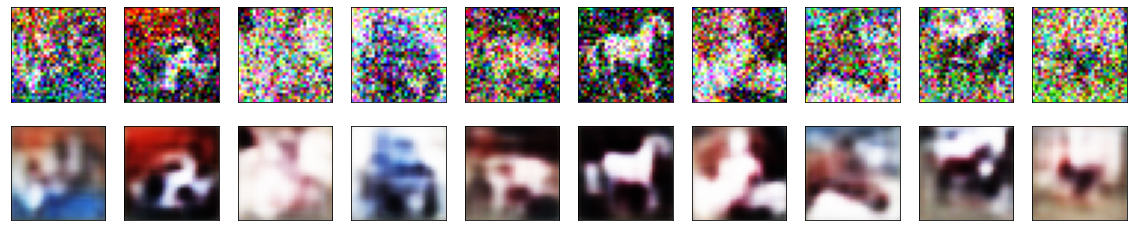

In [7]:
encoded_imgs = autoencoder.encoder(test_images).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

---

## Ciekawostka:
Przypuszczam, że niebawem rozpoczniemy etap kiedy zastanawiać się będziecie jak nie pogubić się w tym, który model do czego służył i który powinniście:
- wziąć do tego, aby go douczyć, 
- który był najbardziej stabliny
- który działał lepiej ale był bardzo eksperymentalny itd...

Z gita więkoszość z Was korzysta pewnie już od 1. roku studiów, niczym dziwnym będzie zatem jak przedstwię rozbudowany system kontroli wersji dla projektów siecioneuronowych. System nazywa się DVC i więcej poczytać można o nim tutaj: [DVC info](https://dvc.org/doc/use-cases). Korzystać będziemy z tego w przyszłym semestrze :)

Miłej lektury!